In [1]:
from utils.binaries import *
from utils.plotting import *
from utils.Auger.SD import Monit
from utils import CONSTANTS
import os, sys

15:30:33 (  +21.8s) [INFO   ] -- import logging
15:30:33 (    +1ms) [INFO   ] -- import numpy as np
15:30:33 (    +5ms) [INFO   ] -- import uncertainties
15:30:33 (    +1ms) [INFO   ] -- import numpy as np
15:30:33 (    +5ms) [INFO   ] -- import uncertainties
15:30:33 (  +235ms) [INFO   ] -- import pandas as pd
15:30:33 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
15:30:33 (    +2ms) [INFO   ] -- import binaries.tools as tools
15:30:34 (  +282ms) [INFO   ] -- import matplotlib.pyplot as plt
15:30:34 (  +400ms) [INFO   ] -- import seaborn as so
15:30:34 (    +2ms) [INFO   ] -- import plotting.tools as plot
15:30:34 (    +6ms) [DEBUG  ] -- font size set to 9.5
15:30:34 (    +1ms) [DEBUG  ] -- label size set to 13.0
15:30:34 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
15:30:34 (    +1ms) [DEBUG  ] -- markersize set to 2.0
15:30:34 (    +0ms) [DEBUG  ] -- usetex set to False


In [10]:
version = 'v43'
base = f'/cr/data01/filip/Data/daqIntegrationTests/{version}/'
monit_files = [f"{base}/{f}" for f in os.listdir(base) if f.startswith('mc')]

muonfill = np.loadtxt(f"{base}/calib.test")
trigger2 = Monit(*monit_files)

17:22:07 (+4143.8s) [INFO   ] -- received 3 file(s) as input
17:22:07 (  +282ms) [INFO   ] -- View monit keys with self.keys()


In [11]:
def pair_indices(ti, tj) -> dict:
    return {i : np.argmin(np.abs(i - tj)) for i in ti}

def ssd_chi2_minimization(version: str, X: np.ndarray, tm) -> np.ndarray:
    t, mip, err = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/ssd_fits.txt', unpack=True)

    idx = [np.argmin(np.abs(tx - tm)) for tx in t]
    chi2 = np.zeros_like(X)

    for i, x in enumerate(X):
        chi2[i] = np.sum( (x*muonfill[:, -2][idx] - mip)**2/err**2 )

    return chi2

17:29:32 (  +10.3s) [DEBUG  ] -- font size set to 9.5
17:29:32 (    +2ms) [DEBUG  ] -- label size set to 13.0
17:29:32 (    +2ms) [DEBUG  ] -- figure size set to [3.3, 2.5]
17:29:32 (    +1ms) [DEBUG  ] -- markersize set to 2.0
17:29:32 (    +1ms) [DEBUG  ] -- usetex set to False
17:29:32 (   +13ms) [INFO   ] -- found 488 entries for key fTime and station #609
17:29:32 (   +62ms) [INFO   ] -- found 488 entries for key fPeak and station #609


Text(0.5, 0, 'DAQ time / h')

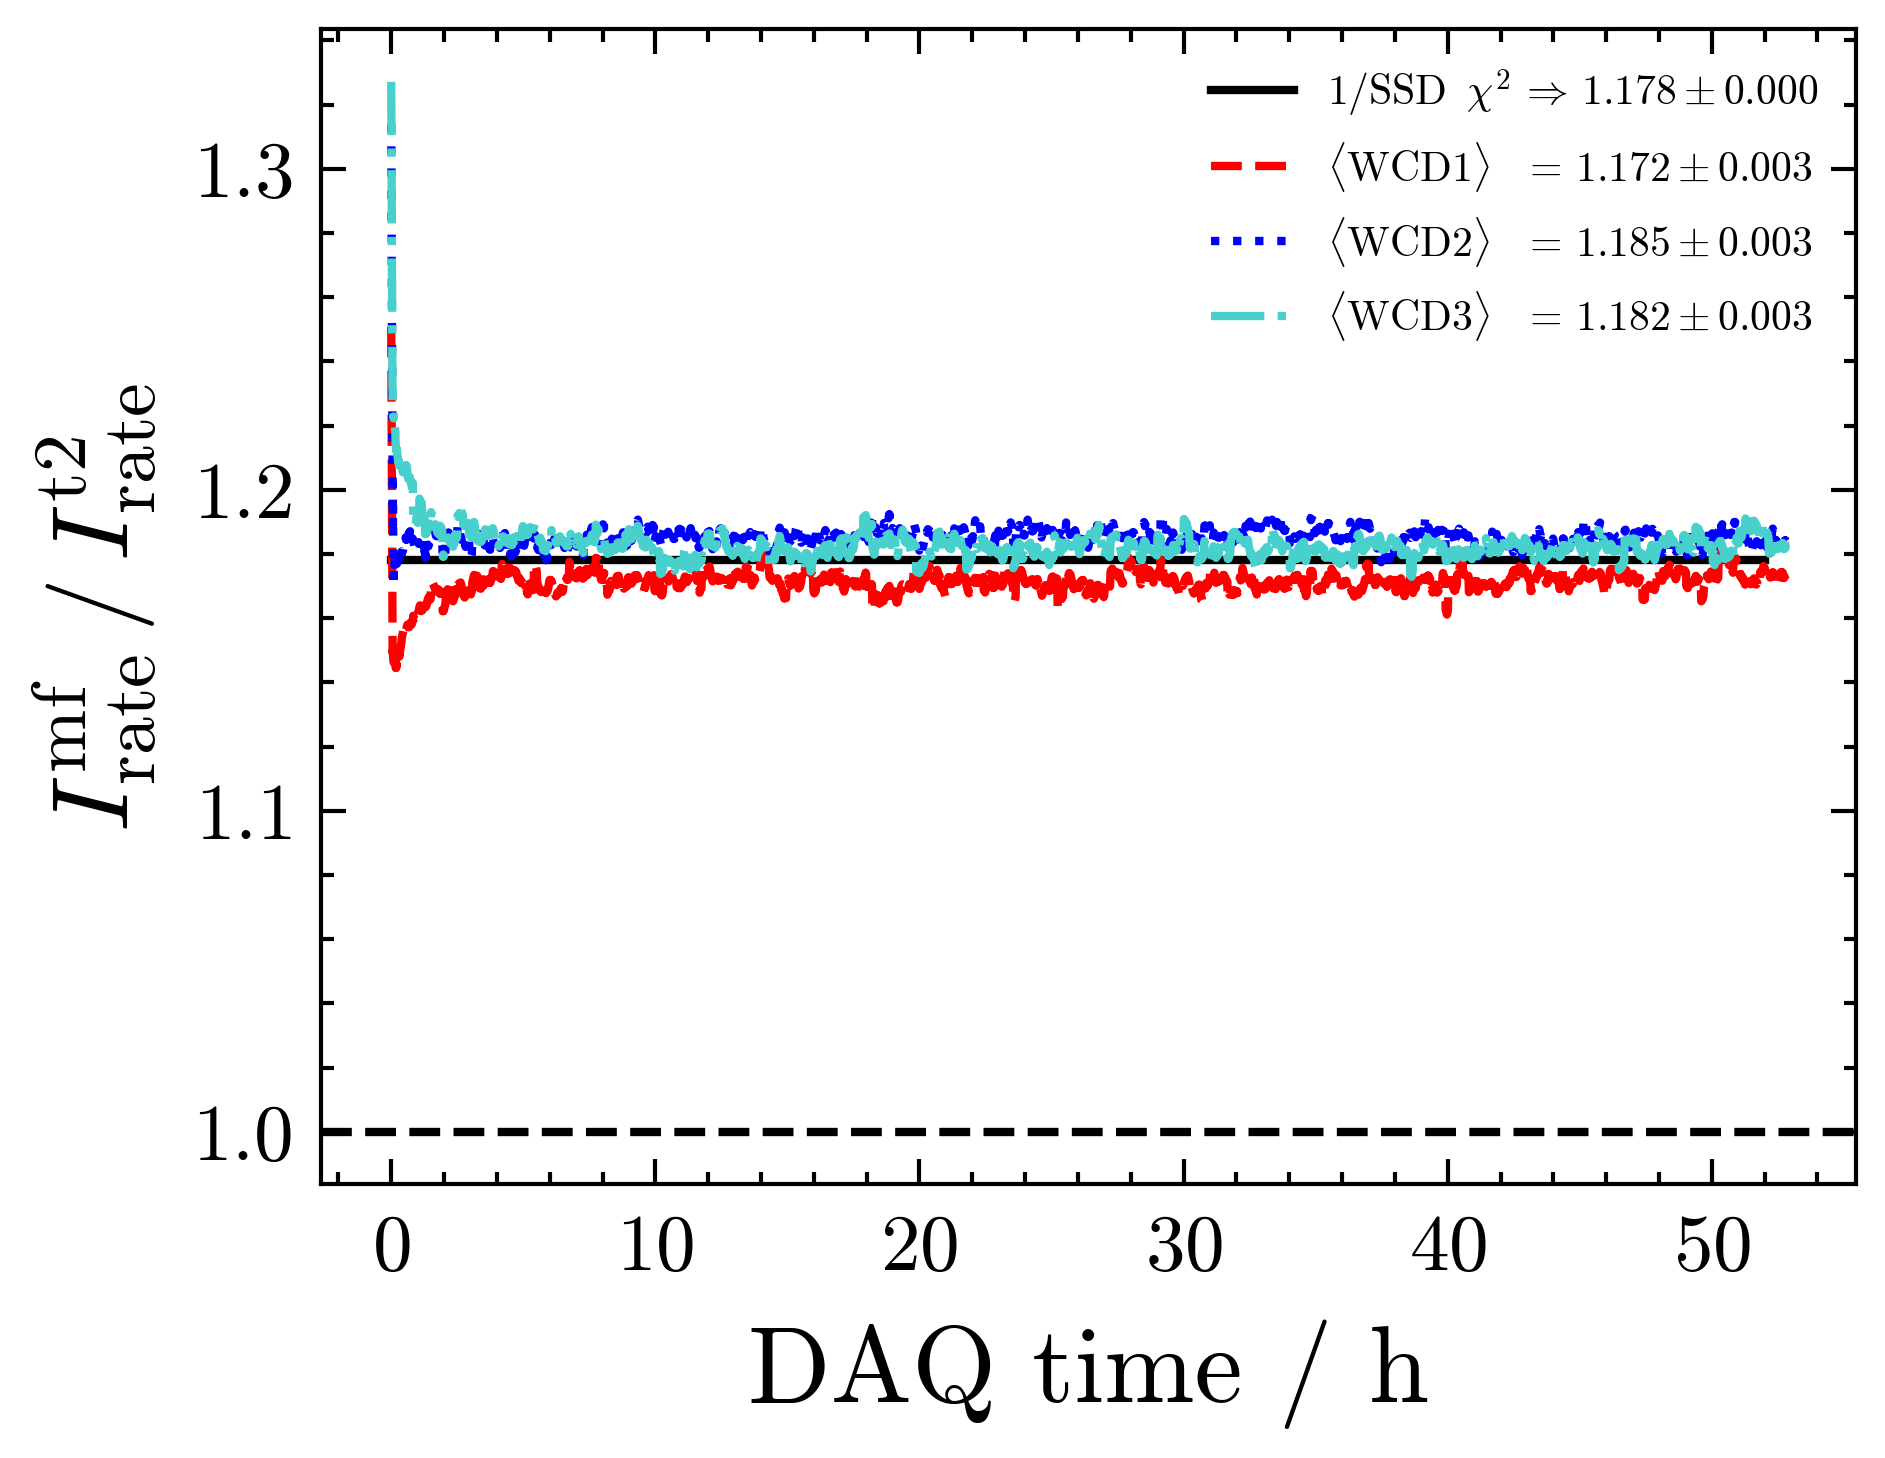

In [26]:
colors = ['r', 'b', 'mediumturquoise']
labels = ['WCD1', 'WCD2', 'WCD3']

set_plt_style('double')

t_muonfill = muonfill[:, 0] + CONSTANTS.GPS_OFFSET
t_trigger2 = trigger2('fTime', 609)

pairs = pair_indices(t_muonfill, t_trigger2)
vems_trigger2 = trigger2('fPeak', 609)
vems_muonfill = muonfill[:, 1:-2:2]

ratios = (vems_muonfill / np.array([vems_trigger2[pairs[t]] for t in t_muonfill])).T / 1.17

scale_ssd = np.linspace(1.174, 1.178, 1000)
chi2_ssd = ssd_chi2_minimization(version, scale_ssd, t_muonfill)
argmin = np.argmin(chi2_ssd)
chi2_pos = scale_ssd[argmin]
min_chi2 = chi2_ssd[argmin]

pos_err = scale_ssd[np.argmin(np.abs( min_chi2 + 0.5 - chi2_ssd[:argmin] ))]
neg_err = scale_ssd[np.argmin(np.abs( min_chi2 + 0.5 - chi2_ssd[argmin:] )) + argmin]
err = np.mean(np.abs(chi2_pos - np.array([pos_err, neg_err])))


plt.plot([0, 52], [chi2_pos for _ in range(2)], 
         label=rf'1/SSD $\,\chi^2\,\Rightarrow\,{chi2_pos:.3f}\pm{err:.3f}$')
# plt.axhspan(*1/(scale_ssd[min_chi2] - np.array([neg_err, pos_err])), color='k', alpha=0.1)

skip = 400
for r, c, l in zip(ratios, colors, labels):
    m, s = np.mean(r[skip:]), np.std(r[skip:])
    plt.plot((t_muonfill - t_muonfill[0]) / 3600, r, c=c, label=rf'$\langle\mathrm{{{l}}}\rangle\ \ \,=\,{m:.3f}\pm{s:.3f}$')

plt.legend(fontsize=5)
# plt.axvline((t_muonfill[skip]-t_muonfill[0]) / 3600, c='k', lw=0.2, ls='--')
plt.axhline(1, c='k', ls='--')

plt.ylabel(r"$I^\mathrm{mf}_\mathrm{rate}\,/\,I^\mathrm{t2}_\mathrm{rate}$")
plt.xlabel('DAQ time / h')
# plt.ylim(0, 1.40)

In [5]:
print(np.mean(ratios[:,skip:]))

1.179323908915455


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_ylabel'

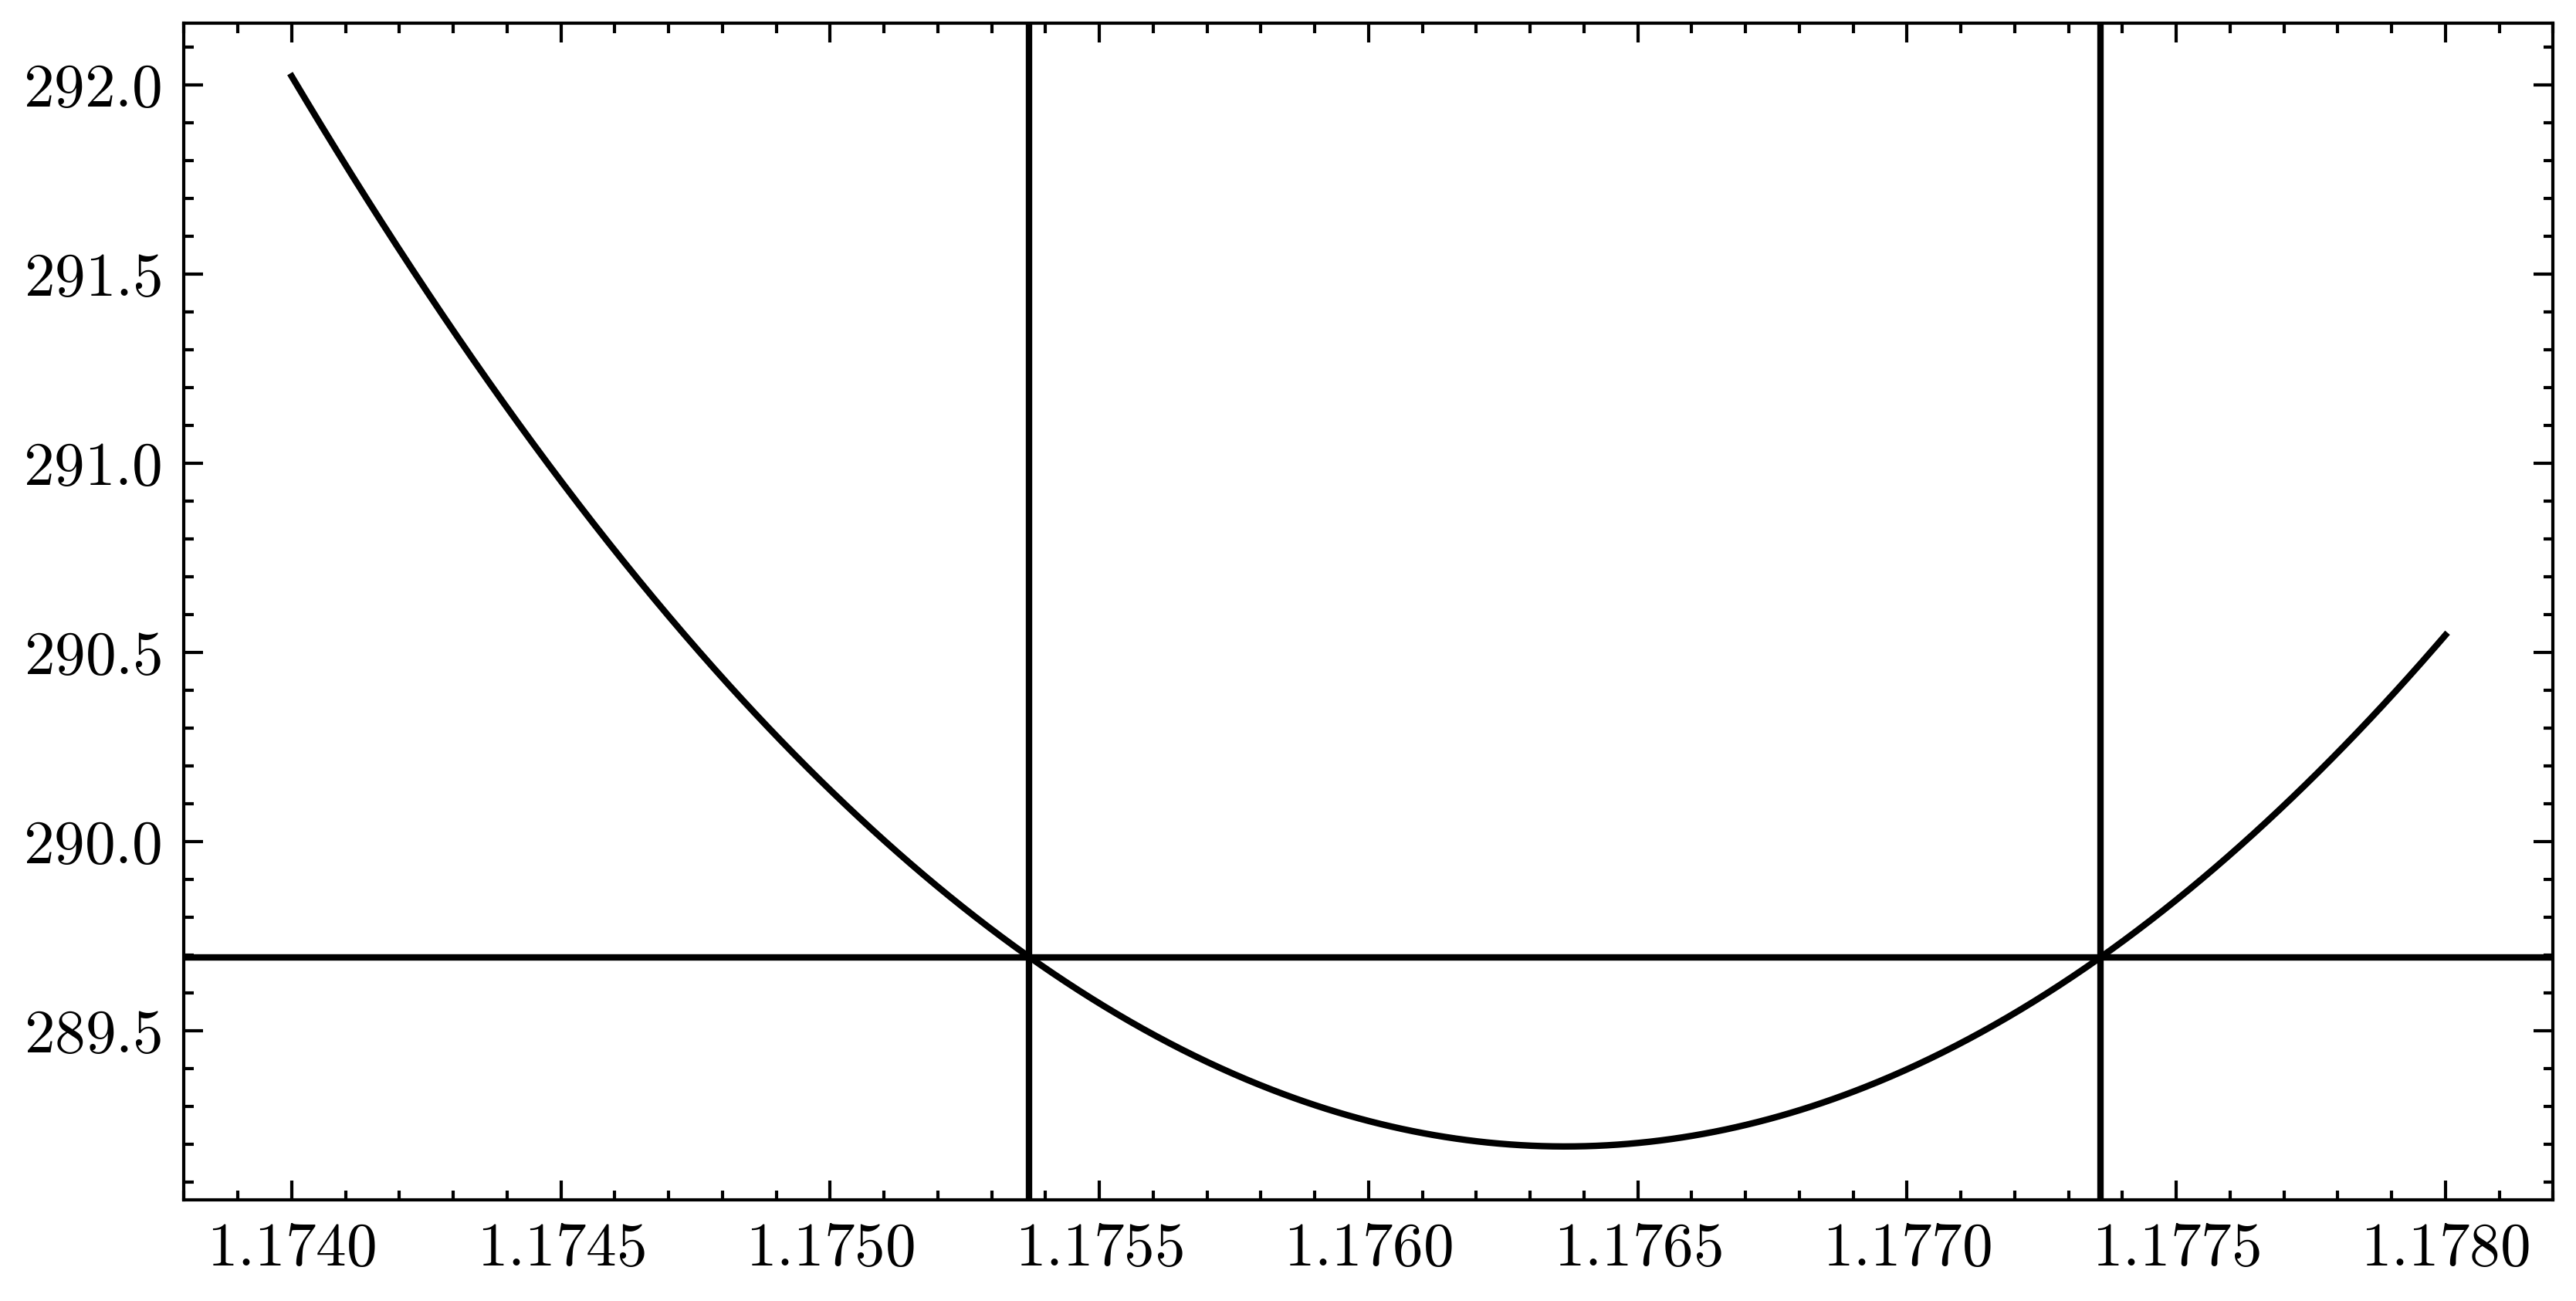

In [15]:
plt.plot(scale_ssd, chi2_ssd)
plt.axhline(min_chi2 + 0.5)

pos_err = np.argmin(np.abs( min_chi2 + 0.5 - chi2_ssd[:argmin] ))
neg_err = np.argmin(np.abs( min_chi2 + 0.5 - chi2_ssd[argmin:] )) + argmin
plt.axvline(scale_ssd[pos_err])
plt.axvline(scale_ssd[neg_err])

plt.set_ylabel(r"$I^\mathrm{muonfill}_\mathrm{rate}\,/\,I^\mathrm{trigger2}_\mathrm{rate}$")

In [ ]:
print()